In [1]:
from utils.parsing import parse_snp500
from utils.data import TradingDataset, show_data

from torch.utils.data import DataLoader

# from models.ConvNN import

# Устанавливаем гиперпараметры

In [2]:
MAX_LENGHT = 180
TEST_LENGHT = 30
SPLIT_COEFF = 0.1
BATCH_SIZE = 32

# Парсим данные snp500 в папку "data/" если их нет

In [3]:
# # парсим данные за последние 7+ лет (выборка большего размера просто не влезет в память)
# parse_snp500(dirpath='data/', 
#              start='2017-01-01', 
#              timeframe='1d', 
#              max_train_len=180, 
#              test_len=30, 
#              split_coeff=0.1)

# Создаём loader'ы для train и val выборок

In [4]:
# Получаем датасеты данных для обучения и валидации
train_dataset = TradingDataset(root_dir="data/train", train_len=180, test_len=30)
val_dataset = TradingDataset(root_dir="data/val", train_len=180, test_len=30)

print(f"Train dataset lenght: {len(train_dataset)}\nValidation dataset lenght: {len(val_dataset)}\n")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train loader lenght: {len(train_loader)}\nValidation loader lenght: {len(val_loader)}")

Train dataset lenght: 678151
Validation dataset lenght: 74911

Train loader lenght: 21193
Validation loader lenght: 2341


# Посмотрим на то что хранится в loader'ах

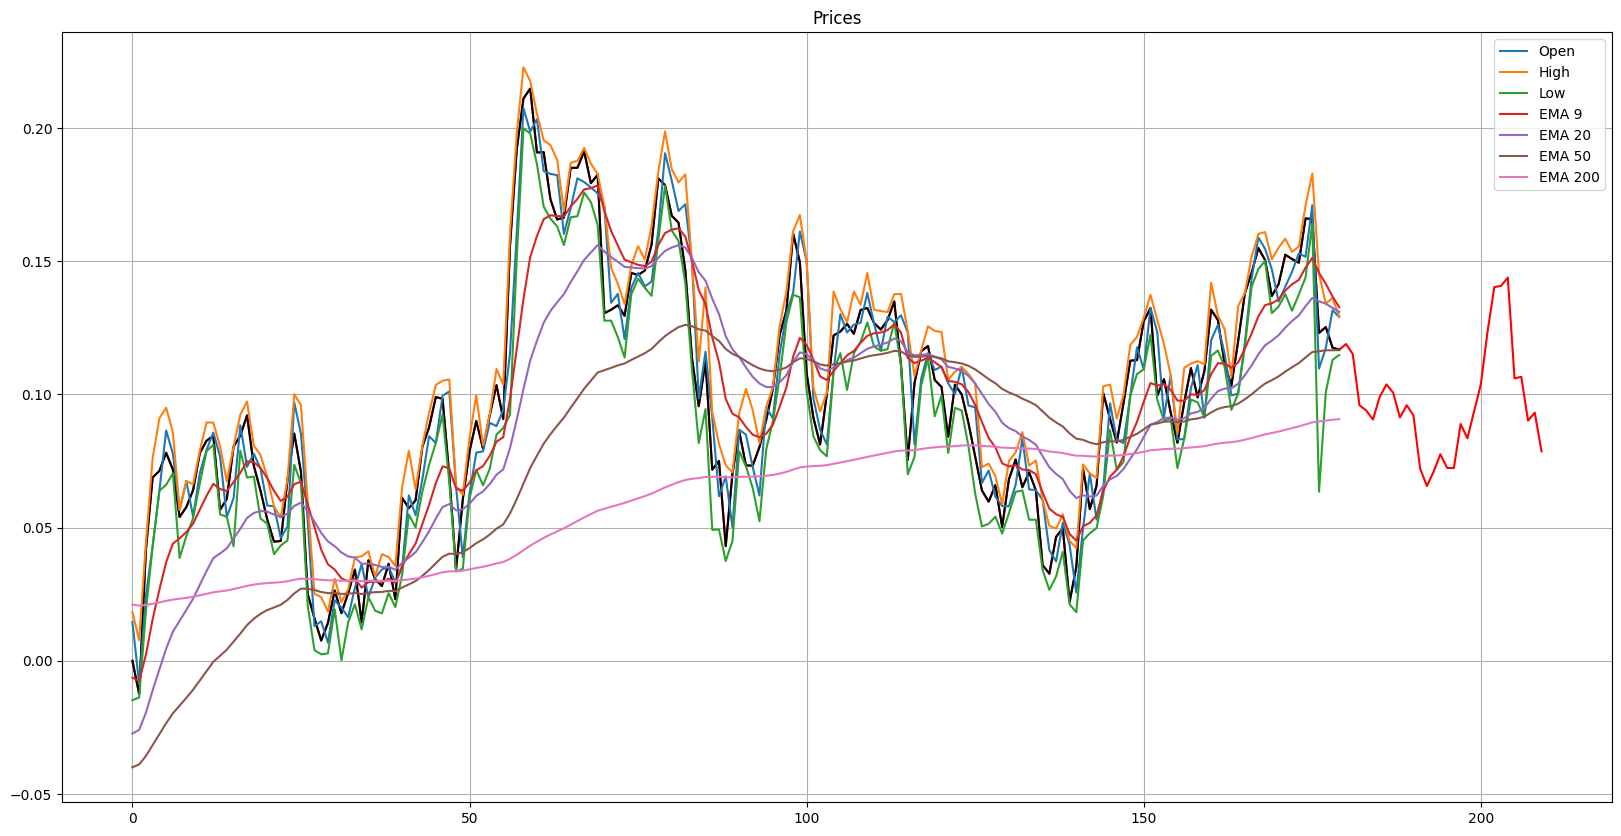

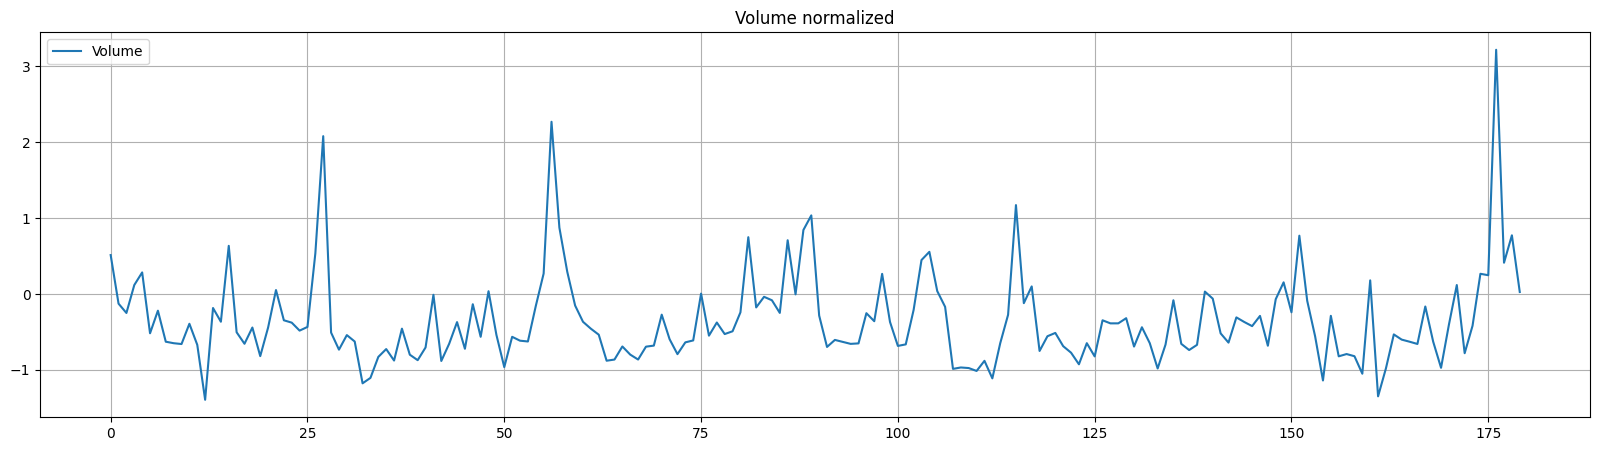

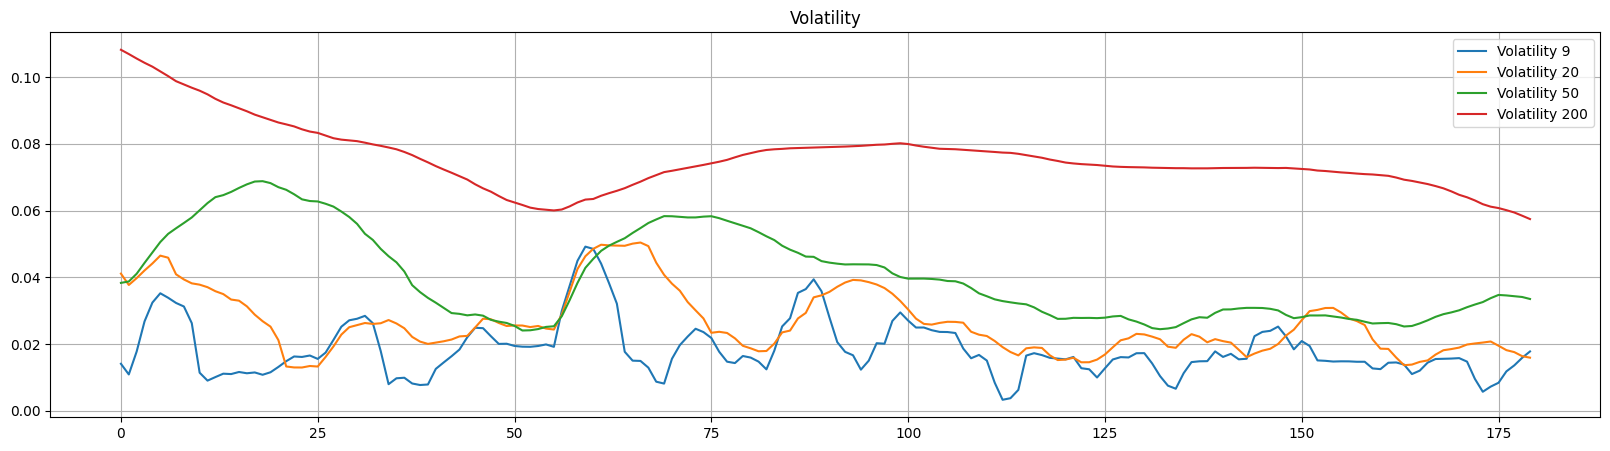

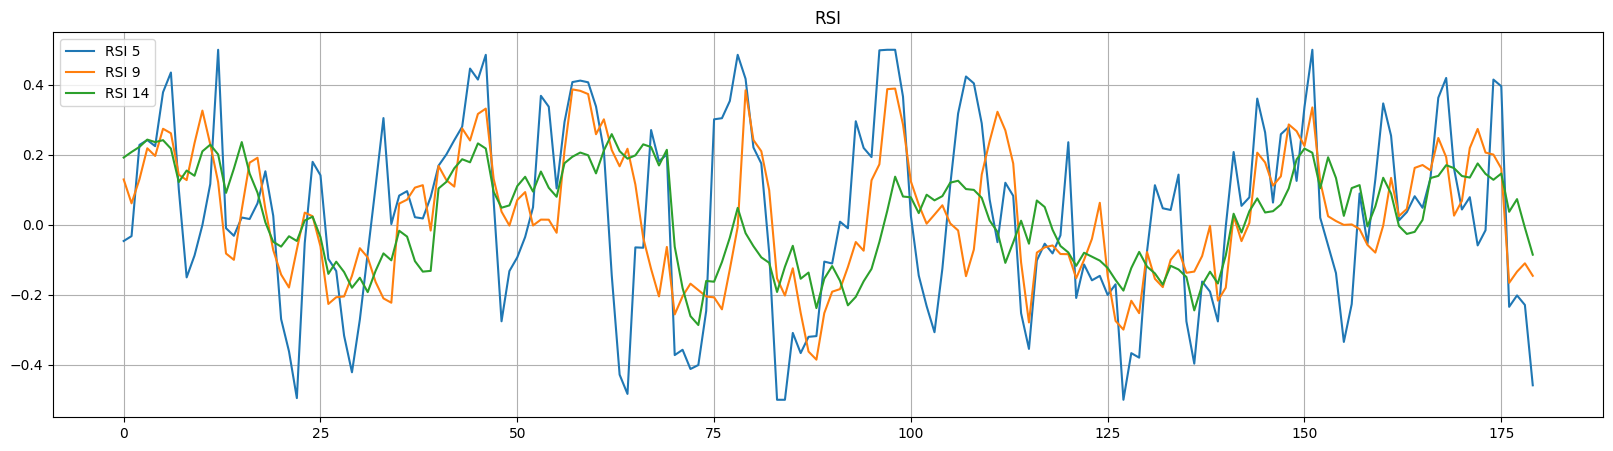

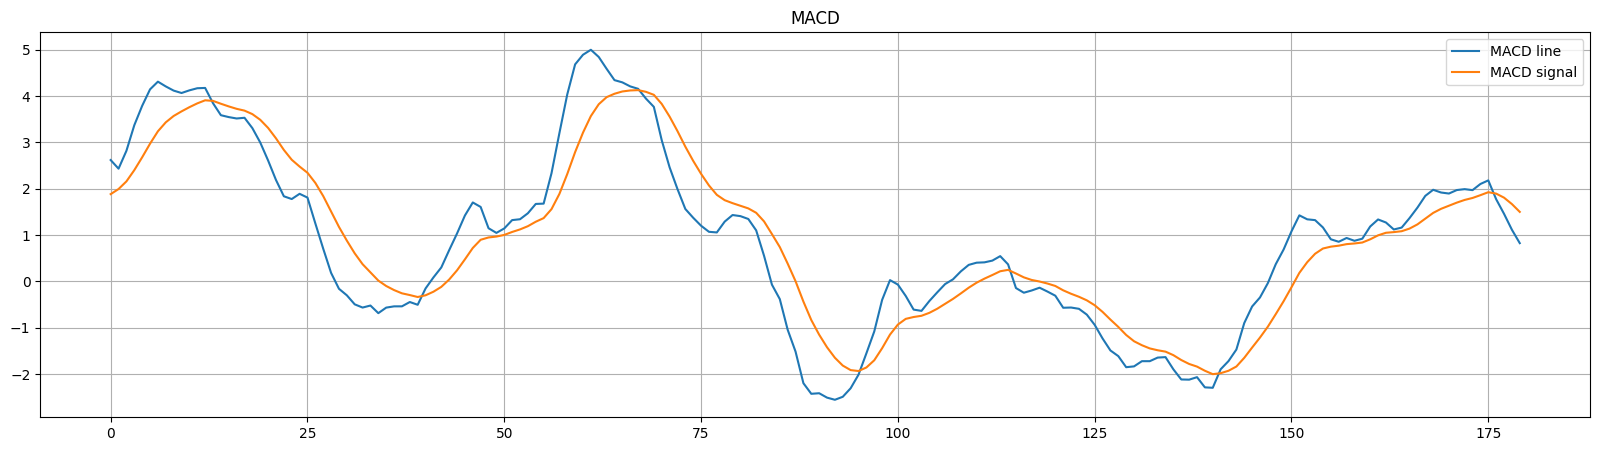

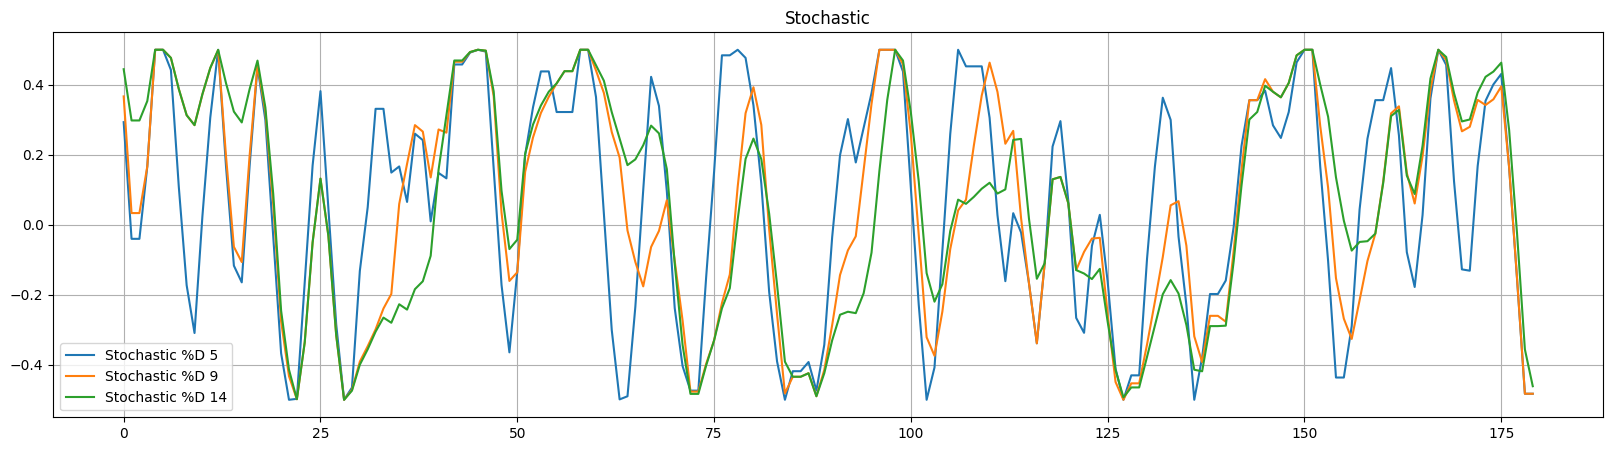

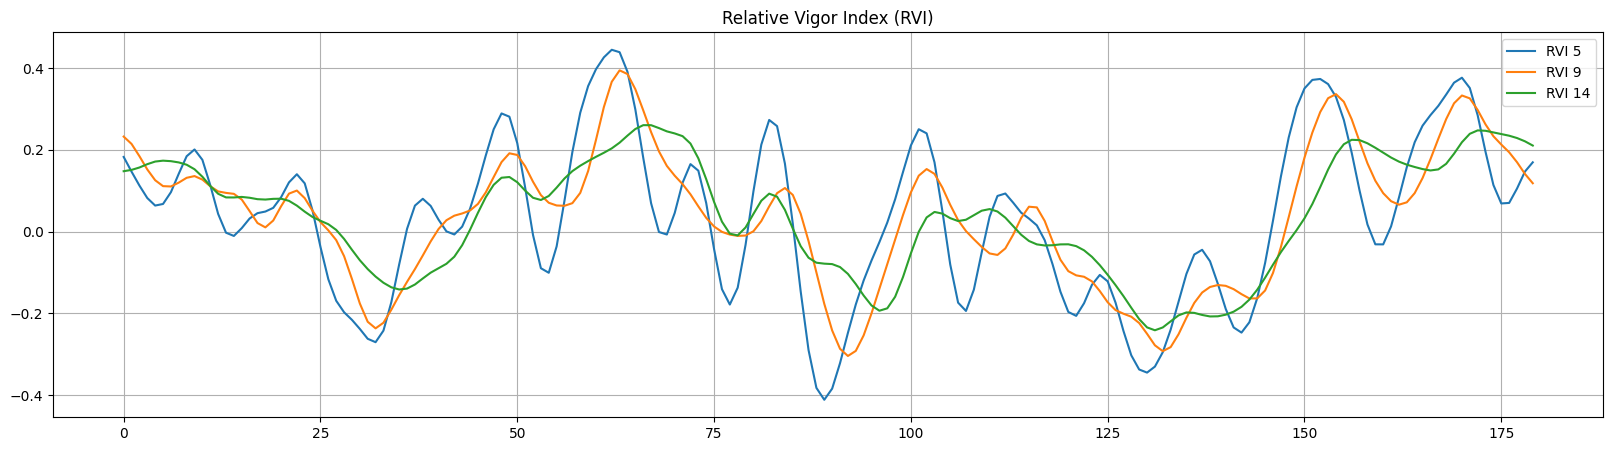

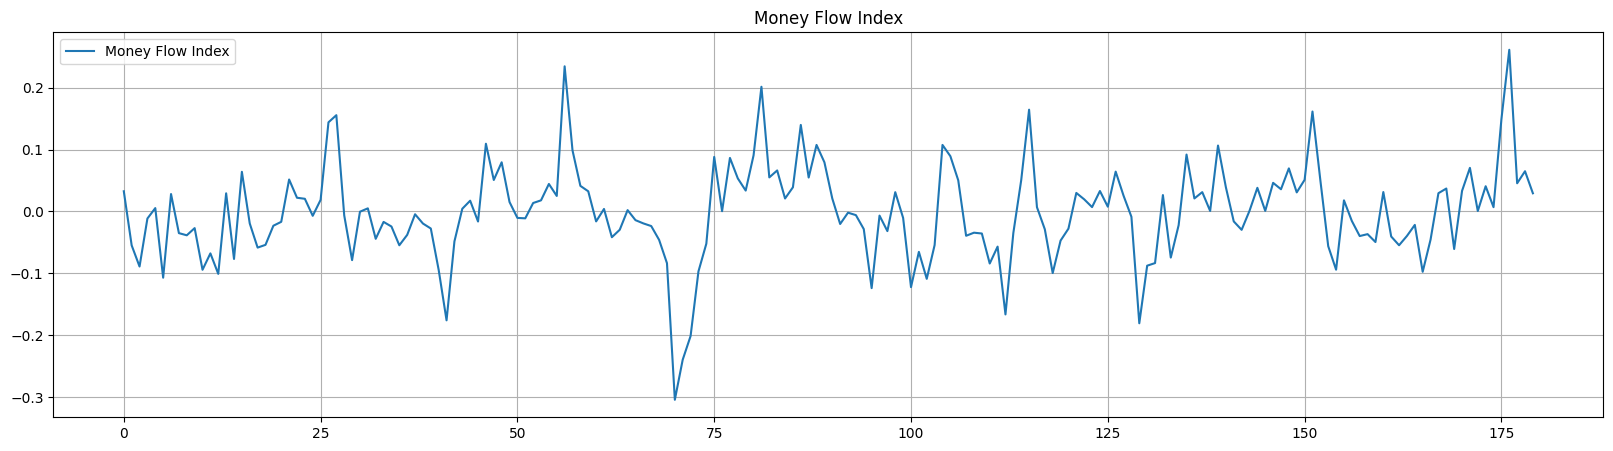

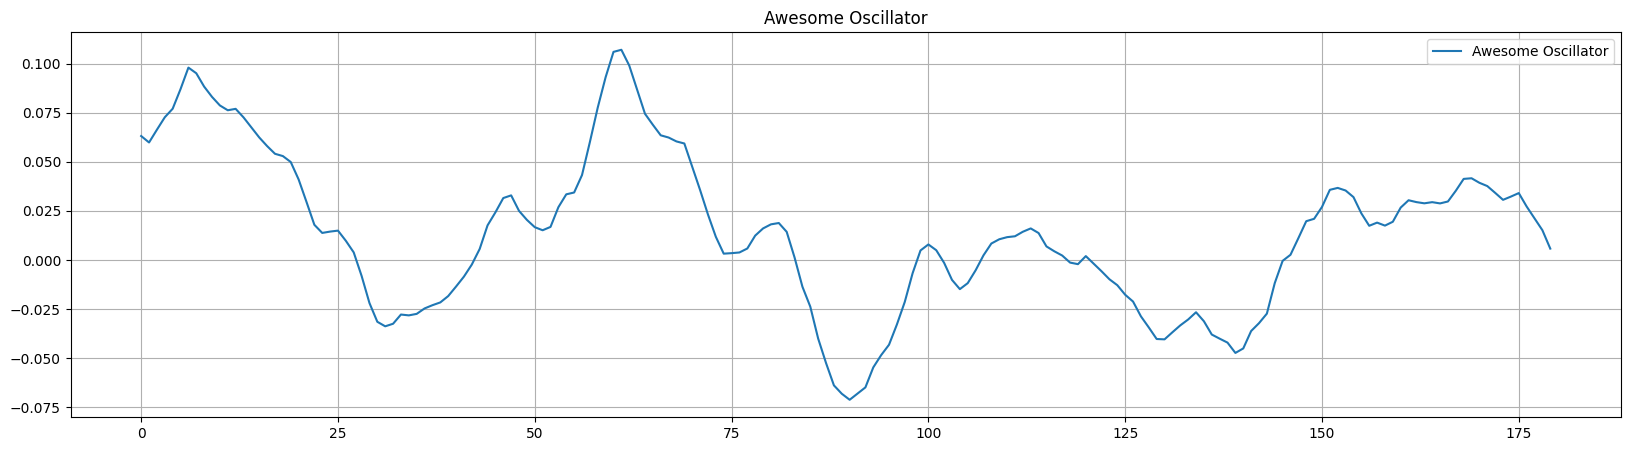

In [6]:
show_data(val_loader)

# Инициализируем модель

In [8]:
import torch
import torch.nn as nn



class FullyConvNN (nn.Module):
    pass